In [276]:
import pandas as pd
import numpy as np
import os

In [277]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [278]:
import matplotlib as mpl
from matplotlib.pyplot import cm

In [279]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [280]:
import statsmodels.stats.multitest as multi

In [281]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [282]:
import sys
sys.path.insert(0, "/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
from sklearn import linear_model
from regressors import stats

In [283]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

## Compile RNA data

In [284]:
def combine_rna(lst_rna,genes):
    compiled=pd.DataFrame()
    for x in lst_rna:
        df=pd.read_csv(x,delimiter="\t")
        del df["IID"]
        df=df.set_index("FID")
        df=df.T
        compiled=compiled.append(df)
    #subset for genes
    compiled=compiled[compiled.index.isin(genes)]
    #replace missing values with nan
    compiled=compiled.replace(-9,np.nan)
    #get median
    compiled=compiled.groupby(compiled.index).median()
    #remove patients with more than 10% of phenotypes as missing
    df_counts=compiled.isnull().sum().reset_index()
    remove=df_counts[df_counts[0]>0.1*741]["index"].tolist()
    
    compiled=compiled.T
    compiled=compiled[~compiled.index.isin(remove)]
    return(compiled)
    

In [285]:
lst=["/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/tpm/tumor/pheno_all_zcancer","/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/firebrowse/tumor/pheno_all_zcancer","/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/pancanatlas/tumor/pheno_all_zcancer"]

In [286]:
#get only genes found in at least 2 rna sources
genes=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/heritability/data/immune.genes.2.rna.txt")["genes"].tolist()

In [287]:
df=combine_rna(lst,genes)

In [288]:
df.to_csv("../data/rna.3source.median.tsv",sep="\t")

## Run PCA

In [289]:
for_pca=df.fillna(df.mean())

In [290]:
#scale data
scaler=StandardScaler()
scaler.fit(for_pca)
X_scaled=scaler.transform(for_pca)

In [291]:
pca = PCA(n_components=30)

In [292]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### plot variance explained

In [293]:
mp_variance={}

for i,val in enumerate(pca.explained_variance_ratio_.tolist()):
    key="PC"+str(i+1)
    mp_variance[key]=val

Text(0, 0.5, 'variance explained')

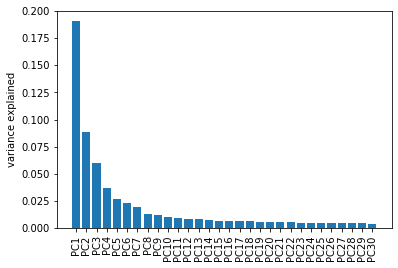

In [294]:
plt.bar(["PC"+str(i) for i in range(1,31)],pca.explained_variance_ratio_.tolist())
plt.xticks(rotation=90)
plt.ylabel("variance explained")

### Get loadings

In [295]:
df_comp=pd.DataFrame(pca.components_)
df_comp.columns=for_pca.columns
df_comp=df_comp.reset_index()
df_comp["index"]=df_comp["index"]+1
df_comp["index"]="PC"+df_comp["index"].astype(str)
df_comp=df_comp.set_index("index")

In [296]:
df_comp=df_comp.T

### Get PCA dataframe

In [297]:
X_pca=pca.transform(X_scaled)

In [298]:
df_pca=pd.DataFrame(X_pca)
df_pca.index=for_pca.index
df_pca.columns=["PC"+str(x+1) for x in df_pca.columns]

In [299]:
df_pca=df_pca.reset_index()

In [300]:
df_pca=df_pca.rename(columns={"index":"FID"})

In [301]:
df_pca.head()

,FID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,TCGA-02-0047,1.784878,-13.136039,4.176151,2.460379,0.400791,-0.148301,2.791126,-0.105374,0.010016,...,-2.455380,3.660096,-1.799302,0.742903,-1.299887,0.136713,-1.668759,-2.861316,-1.421050,0.291664
1,TCGA-02-0055,16.918275,4.185216,-1.992375,10.003828,8.132131,1.488629,-2.358534,-1.154243,-6.485764,...,0.333536,-2.743252,-0.897605,2.718327,-1.408442,-0.563367,-0.843371,1.849445,-3.008393,0.913241
2,TCGA-02-2486,19.289779,4.730709,2.554748,-5.560061,11.298650,-4.962419,-3.220632,3.133149,1.483822,...,3.441931,1.352772,0.666845,-1.523764,3.395424,0.449743,-0.078455,0.083451,-0.635606,-0.639430
3,TCGA-06-0129,9.078634,-6.140409,-11.869147,-8.358886,-9.092636,-3.038194,2.242685,7.884887,4.774635,...,-4.258958,0.846833,0.124200,2.230995,-2.541778,-1.645636,3.017639,-2.042657,-1.350877,2.880457
4,TCGA-06-0130,32.573026,1.812918,-5.821779,4.159500,0.385653,0.254406,-2.122522,1.247559,-6.140834,...,1.697157,-3.146647,5.148091,1.519063,-0.252545,-1.483842,1.295944,1.745332,-2.809712,-0.305398


### Run regression with principal components

In [302]:
df=df.reset_index().rename(columns={"index":"FID"})

In [303]:
all_pheno=pd.merge(df_pca,df,on=["FID"],how="left")

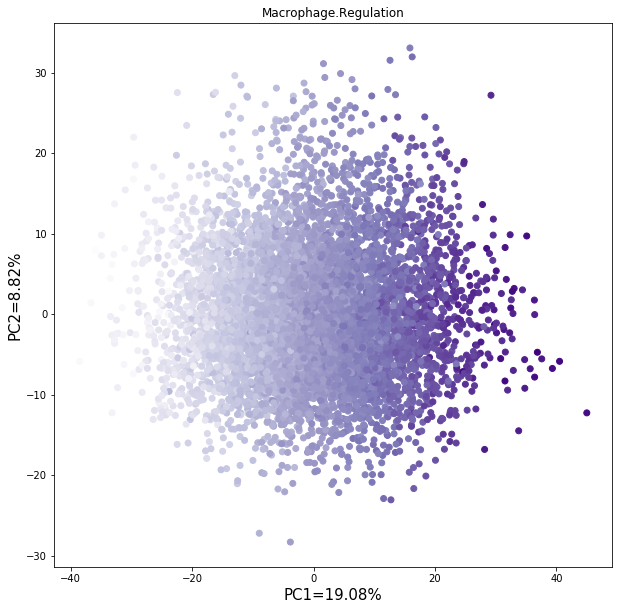

In [304]:
f=plt.figure(figsize=(10,10))

x="PC1"
y="PC2"
gene="Macrophage.Regulation"

plt.scatter(all_pheno[x], all_pheno[y], c=all_pheno[gene],cmap="Purples")


plt.xlabel(x+"="+"{0:.2f}%".format(mp_variance[x]*100),fontsize=15)
plt.ylabel(y+"="+"{0:.2f}%".format(mp_variance[y]*100),fontsize=15)
plt.title(gene)
plt.savefig("../plots/"+x+"."+gene+".pdf")

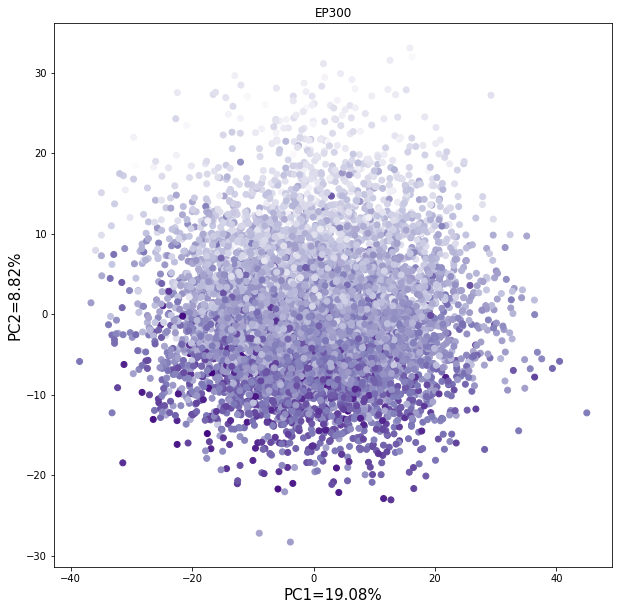

In [305]:
f=plt.figure(figsize=(10,10))

x="PC1"
y="PC2"
gene="EP300"

plt.scatter(all_pheno[x], all_pheno[y], c=all_pheno[gene],cmap="Purples")


plt.xlabel(x+"="+"{0:.2f}%".format(mp_variance[x]*100),fontsize=15)
plt.ylabel(y+"="+"{0:.2f}%".format(mp_variance[y]*100),fontsize=15)
plt.title(gene)
plt.savefig("../plots/"+x+"."+gene+".pdf")

## Run OLS with cancer type

In [307]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
df_pca["cancer"]=df_pca["FID"].map(mp)

In [309]:
df_pca_cancer=df_pca.join(pd.get_dummies(df_pca["cancer"]))

In [312]:
pcs=df_pca_cancer.columns[1:11]
cancers=df_pca_cancer.columns[32:]

In [325]:
cancer=[]
pc=[]
pval=[]

for x in pcs:
    for c in cancers:
        ols = linear_model.LinearRegression()
        X=df_pca_cancer[c].values.reshape(-1, 1)
        y=df_pca_cancer[x].values.reshape(-1, 1)
        
        X = sm.add_constant(X)
        
        model=sm.OLS(y,X)
        results=model.fit()
        
        cancer.append(c)
        pc.append(x)
        pval.append(results.pvalues[1])


In [329]:
cancer_ols=pd.DataFrame({"cancer":cancer,"pc":pc,"pvalue":pval})

In [331]:
cancer_ols.to_csv("../data/pcs.cancer.type.ols.csv",index=None,sep="\t")

## Run association with Age/Sex

In [332]:
cov=pd.read_csv("/cellar/users/mpagadal/Data/plink-associations/covs/cov-immune-filt.txt",delimiter="\t")
mp_age=dict(zip(cov["FID"],cov["age"]))

In [334]:
fam=pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam",delim_whitespace=True,header=None)
mp_sex=dict(zip(fam[0],fam[4]))

In [335]:
df_pca["age"]=df_pca["FID"].map(mp_age)
df_pca["sex"]=df_pca["FID"].map(mp_sex)

In [337]:
pcs=df_pca.columns[1:11]

In [341]:
var=[]
pc=[]
pval=[]

for x in pcs:
    for c in ["age","sex"]:
        ols = linear_model.LinearRegression()
        X=df_pca[c].values.reshape(-1, 1)
        y=df_pca[x].values.reshape(-1, 1)
        
        X = sm.add_constant(X)
        
        model=sm.OLS(y,X)
        results=model.fit()
        
        var.append(c)
        pc.append(x)
        pval.append(results.pvalues[1])

In [342]:
age_sex_ols=pd.DataFrame({"variable":var,"pc":pc,"pvalue":pval})

In [346]:
age_sex_ols=age_sex_ols.pivot(index="pc",columns="variable",values="pvalue")

In [348]:
age_sex_ols.to_csv("../data/pcs.age.sex.ols.csv",index=None,sep="\t")

## Run PCA for just heritable phenotypes

In [224]:
genes=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/heritability/data/gcta_significant_genes.txt",header=None)[0].tolist()

In [225]:
df=combine_rna(lst,genes)

In [226]:
df.head()

,ADCY7,ALOX5AP,AMPD3,APITD1,B2M,BSG,BTN3A2,C3AR1,CANX,CAPZA2,...,TLR2,TNFRSF1A,TNFSF13B,TRA2B,TRAF6,TREX1,UAP1,VAMP3,VSIG4,WDR54
TCGA-02-0047,1.538334,-0.041444,0.020717,-0.720732,-0.381976,-1.365388,0.124617,-0.136196,0.668002,-0.592197,...,0.359785,-0.351784,0.472789,-1.018725,-1.091620,-0.592197,-0.543513,0.720732,-0.187537,-0.918546
TCGA-02-0055,0.052245,1.605730,0.178496,0.351784,1.419554,0.856599,0.887147,1.018725,-0.465370,0.714367,...,1.686671,0.610295,0.519653,-0.642327,-0.199762,-0.031338,2.641070,1.213340,1.213340,0.560703
TCGA-02-2486,0.136196,2.241403,0.687660,1.267664,1.893185,-0.826830,1.018725,1.686671,0.136196,0.536422,...,1.267664,0.648915,1.534121,-1.135422,0.324048,0.747859,0.887147,1.900427,1.686671,0.585319
TCGA-06-0129,2.638257,-0.010273,0.351784,0.010273,0.700514,-0.175539,0.610295,1.410699,-0.585319,-0.781640,...,1.356312,-1.900427,0.700514,1.223048,1.130339,0.838697,0.199762,-0.526759,0.754049,-0.285841
TCGA-06-0130,2.241403,0.700514,1.893185,1.258162,1.896823,-0.574582,1.415149,2.036834,-0.741594,0.635657,...,2.241403,0.560703,1.896823,-0.404357,-0.898625,-0.154711,2.040281,0.781640,1.170831,-0.694126


In [227]:
for_pca=df.fillna(df.mean())

In [228]:
scaler=StandardScaler()
scaler.fit(for_pca)
X_scaled=scaler.transform(for_pca)

In [229]:
pca = PCA(n_components=30)

In [230]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [231]:
mp_variance={}

for i,val in enumerate(pca.explained_variance_ratio_.tolist()):
    key="PC"+str(i+1)
    mp_variance[key]=val

Text(0, 0.5, 'variance explained')

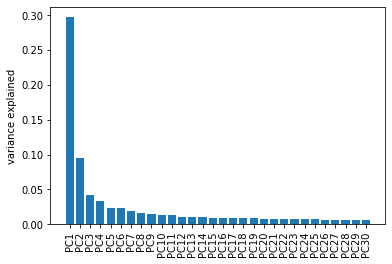

In [232]:
plt.bar(["PC"+str(i) for i in range(1,31)],pca.explained_variance_ratio_.tolist())
plt.xticks(rotation=90)
plt.ylabel("variance explained")

In [233]:
df_comp=pd.DataFrame(pca.components_)
df_comp.columns=for_pca.columns
df_comp=df_comp.reset_index()
df_comp["index"]=df_comp["index"]+1
df_comp["index"]="PC"+df_comp["index"].astype(str)
df_comp=df_comp.set_index("index")

In [234]:
df_comp=df_comp.T

In [235]:
X_pca=pca.transform(X_scaled)

In [236]:
df_pca=pd.DataFrame(X_pca)
df_pca.index=for_pca.index
df_pca.columns=["PC"+str(x+1) for x in df_pca.columns]

In [237]:
df_pca=df_pca.reset_index()

In [238]:
df_pca=df_pca.rename(columns={"index":"FID"})

In [239]:
df=df.reset_index().rename(columns={"index":"FID"})

In [240]:
rna=pd.read_csv("../data/rna.3source.median.tsv",delimiter="\t").rename(columns={"Unnamed: 0":"FID"})

In [241]:
all_pheno=pd.merge(df_pca,rna,on=["FID"],how="left")

In [242]:
neoantigen=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/neoantigen/pheno_all_zcancer",delimiter="\t")
neoantigen=neoantigen.replace(-9,np.nan)

In [243]:
all_pheno=pd.merge(all_pheno,neoantigen,on=["FID"],how="left")

In [244]:
all_pheno.head()

,FID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,dice.CD8_STIM,dice.M2,dice.TH1,melanoma.CAF,melanoma.Macrophages,IID,I.thresh2,II.thresh20,I.thresh0.5,II.thresh10
0,TCGA-02-0047,1.313917,-3.680450,-2.795899,-0.931782,-1.040479,-1.262938,0.303152,0.862854,-0.395507,...,-0.775547,1.018725,0.610295,0.404357,0.496085,TCGA-02-0047,0.548210,0.628673,0.129234,0.848990
1,TCGA-02-0055,10.244986,0.949090,0.799508,4.054191,0.697337,-4.204909,-2.015502,1.336556,-0.522838,...,2.638257,0.374095,-0.519653,2.638257,-0.094137,TCGA-02-0055,-0.533294,-0.138987,-0.345023,-0.688715
2,TCGA-02-2486,11.269077,3.172041,2.635634,1.957389,1.474254,-2.568172,2.035558,-1.580825,-1.367217,...,-0.187537,0.984235,1.064979,0.052245,1.410699,TCGA-02-2486,-0.656398,0.400286,-0.087101,0.365614
3,TCGA-06-0129,7.580760,-3.180433,2.907297,-2.147088,-1.486675,3.849731,1.881859,-1.436881,1.610504,...,0.769382,-0.208664,-1.054472,-2.244607,2.641070,TCGA-06-0129,-1.034781,-1.029293,-0.881787,-0.844379
4,TCGA-06-0130,15.852036,-0.546411,0.425581,0.254305,1.312759,-0.784373,-0.972843,0.314640,-0.471974,...,0.082959,1.893185,0.010444,1.686671,1.609816,TCGA-06-0130,-1.034781,-0.877044,-0.609163,-0.688715


In [245]:
pcs=all_pheno.columns[1:11]
phenos=all_pheno.columns[100:124]

In [262]:
phenos=["Macrophage.Regulation","EP300","Proliferation","IFN.gamma.Response","I.thresh2","II.thresh20","LM22.Macrophages.M2","CD274","TAB1","ERAP1"]

In [263]:
all_pheno=all_pheno.fillna(0)

In [264]:
pc=[]
pheno=[]
beta=[]

for x in pcs:
    for p in phenos:
        ols = linear_model.LinearRegression()
        X=all_pheno[p].values.reshape(-1, 1)
        y=all_pheno[x].values.reshape(-1, 1)
        
        X = sm.add_constant(X)
        
        model=sm.OLS(y,X)
        results=model.fit()
        
        beta.append(results.params[1])
        pheno.append(p)
        pc.append(x)

In [265]:
df_ols=pd.DataFrame({"pc":pc,"pheno":pheno,"beta":beta})

In [266]:
df_ols=df_ols.pivot(index="pc",columns="pheno",values="beta")

In [267]:
df_ols.head()

pheno,CD274,EP300,ERAP1,I.thresh2,IFN.gamma.Response,II.thresh20,LM22.Macrophages.M2,Macrophage.Regulation,Proliferation,TAB1
pc,,,,,,,,,,
PC1,3.759759,-0.051271,2.861852,0.157080,3.747248,-0.023646,1.849154,6.130856,-0.051122,-0.804361
PC10,-0.031244,0.124914,-0.084929,0.164458,-0.166038,0.123933,-0.313318,0.055258,0.235817,-0.083940
PC2,-0.814804,-2.380944,-1.402276,0.190709,0.560167,0.204689,-0.057283,0.159569,-0.421294,0.802811
PC3,0.647358,-0.009900,0.734987,0.218461,1.369049,0.183197,-0.684031,-0.302862,0.755756,-0.535600
PC4,-0.087478,-0.651189,-0.391642,0.302230,-0.277125,0.221455,0.490471,-0.133696,0.777293,-0.596483


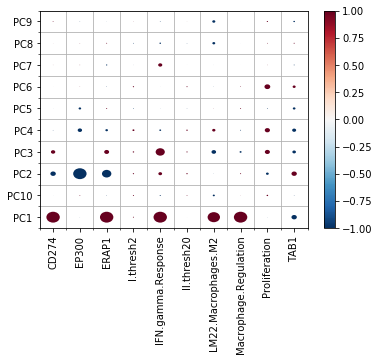

In [268]:
grid=abs(df_ols)
grid[grid > 2] = 2

c=df_ols.copy()
c[c > 0] = 1
c[c < 0] = -1

ylabels = grid.index.tolist()
xlabels = grid.columns.tolist()
N=len(ylabels)
M=len(xlabels)

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = grid.values
c = c.values

fig, ax = plt.subplots()

R = s/s.max()/4
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="RdBu_r")
ax.add_collection(col)

ax.set(xticks=np.arange(len(xlabels)), yticks=np.arange(len(ylabels)),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')
plt.xticks(rotation=90)

fig.colorbar(col)
#plt.savefig(surv_type+".hazards.pdf")

## Get PCs for both gcta and all phenos

In [134]:
gcta=pd.read_csv("../processed_phenos/pca/pca.pheno.heritable.tsv",delimiter="\t")
pheno=pd.read_csv("../processed_phenos/pca/pca.pheno.tsv",delimiter="\t")

In [135]:
all_pca=pd.merge(gcta,pheno,on=["FID","IID"],suffixes=("_all","_gcta"))

In [136]:
del all_pca["FID"]
del all_pca["IID"]

In [137]:
all_pca=abs(all_pca)

In [138]:
all_pca.head()

,PC1_all,PC2_all,PC3_all,PC4_all,PC5_all,PC6_all,PC7_all,PC8_all,PC9_all,PC10_all,PC1_gcta,PC2_gcta,PC3_gcta,PC4_gcta,PC5_gcta,PC6_gcta,PC7_gcta,PC8_gcta,PC9_gcta,PC10_gcta
0,1.313917,3.680450,2.795920,0.931772,1.040448,1.262522,0.303719,0.858296,0.403122,1.461166,1.784737,13.135899,4.176562,2.460464,0.402273,0.146864,2.791070,0.106347,0.010014,2.205814
1,10.244986,0.949089,0.799498,4.054130,0.696704,4.205255,2.016507,1.337999,0.534810,1.097614,16.918073,4.185367,1.991697,10.002315,8.131188,1.491205,2.363470,1.172913,6.483940,2.196060
2,11.269077,3.172041,2.635656,1.957362,1.474086,2.568502,2.037273,1.580704,1.359331,1.795065,19.290299,4.729950,2.553463,5.562093,11.303328,4.955355,3.219751,3.138193,1.477335,3.424130
3,7.580760,3.180431,2.907188,2.147122,1.487361,3.849738,1.881467,1.429179,1.600554,0.506509,9.078792,6.140856,11.869096,8.355814,9.092941,3.041594,2.247341,7.898231,4.755307,0.433890
4,15.852036,0.546411,0.425554,0.254357,1.312823,0.784748,0.974725,0.324995,0.463043,2.749847,32.572916,1.812889,5.821054,4.160008,0.383361,0.253562,2.124778,1.230449,6.145078,0.060518


In [139]:
all_pca_pearson=all_pca.corr(method="pearson")

In [140]:
cols=[x for x in all_pca_pearson.columns if "gcta" in x]
ind=[x for x in all_pca_pearson.columns if "all" in x]

In [141]:
all_pca_pearson_compare=all_pca_pearson.loc[ind,cols]

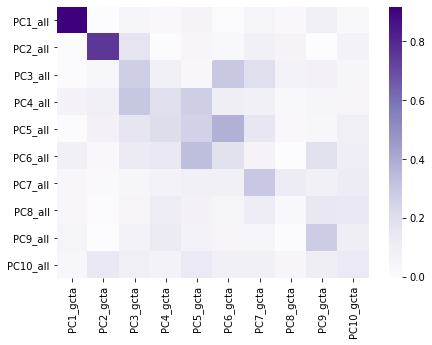

In [142]:
f=plt.figure(figsize=(7,5))
sns.heatmap(all_pca_pearson_compare,cmap="Purples")
plt.savefig("pca.heatmap.pdf")